In [1]:
# Import necessary libraries. 
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import pygeoinf as inf
from pygeoinf.symmetric_space.sphere import Sobolev
import pyslfp as sl
from pyslfp.operators import SeaLevelOperator, GraceObservationOperator, TideGaugeObservationOperator, AveragingOperator

# Set up the FingerPrint instance
fingerprint = sl.FingerPrint(
    lmax=32,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fingerprint.set_state_from_ice_ng()

# Function for generating random ocean locations.
def random_ocean_locations(n, lat1=-90, lat2=90):
    """
    Returns a set of n points within the oceans. An optional
    range of latitudes can be provided.
    """
    points = []
    while len(points) < n:
        lat = np.random.uniform(lat1, lat2)
        lon = np.random.uniform(-180, 180)
        sl = fingerprint.point_evaulation(fingerprint.sea_level, lat, lon)
        if sl > 0:
            points.append([lat, lon])            
    return points

In [2]:
# Set the model space for the ice thickness change. 
order = 2
scale = 0.1

# Set the data error measure for the forward ptoblem.
observation_degree = 10
data_space = inf.EuclideanSpace((observation_degree+1)**2 - 4)
data_error_measure = inf.GaussianMeasure.from_standard_deviation(data_space, 0.01)

# Initialise the forward problem.
rotational_feedbacks = True
rtol = 1e-6

sea_level_operator = SeaLevelOperator(
    order,
    scale,
    fingerprint=fingerprint,
    rotational_feedbacks=rotational_feedbacks,
    rtol=1e-6,
)

observation_operator = GraceObservationOperator(
    sea_level_operator, 
    observation_degree
)

gfp = inf.LinearForwardProblem(
    observation_operator.forward_operator,
    data_error_measure
)

# Set a prior distribution.
model_space = sea_level_operator.domain
model_prior_measure = model_space.sobolev_gaussian_measure(2, 0.05, 1)

In [3]:
# Debugging
i = 2
response_space = sea_level_operator.codomain
inc = response_space.subspace_inclusion(i)

model1 = model_prior_measure.sample()
model2 = model_prior_measure.sample()
response2 = sea_level_operator(model2)
single_response = inc(response2[i])

LHS = response_space.inner_product(sea_level_operator(model1), single_response)
RHS = model_space.inner_product(model1, sea_level_operator.adjoint(single_response))
print("Test for the self-adjointness of the sea level operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")
print(f"Difference: {np.abs(LHS - RHS)/np.abs(LHS + RHS)}")

Test for the self-adjointness of the sea level operator:
LHS: -1.18246852107047e+16
RHS: -1.1824309826647818e+16
Difference: 1.5873150478026563e-05


In [4]:
gaussian_params = [(0.0002, 73, -42), (0.0002, -79, -112)]
weighting_functions = [fingerprint.gaussian_averaging_function(width, lat, lon) for width, lat, lon in gaussian_params]
property_operator = AveragingOperator(model_space, weighting_functions = weighting_functions, fingerprint=fingerprint)

In [5]:
prop2 = property_operator(model2)

prop_space = property_operator.codomain

lhs = prop_space.inner_product(property_operator(model1), prop2)
rhs = model_space.inner_product(model1, property_operator.adjoint(prop2))
print("Test for the self-adjointness of the property operator:")
print(f"LHS: {lhs}")
print(f"RHS: {rhs}")
print(f"Difference: {np.abs(lhs - rhs)/np.abs(lhs + rhs)}")

Test for the self-adjointness of the property operator:
LHS: -0.08554016815915425
RHS: -0.08554016815915888
Difference: 2.7093593732395884e-14


In [6]:
response_space = sea_level_operator.codomain

model1 = model_prior_measure.sample()
model2 = model_prior_measure.sample()
response2 = sea_level_operator(model2)

i = 2
inc = response_space.subspace_inclusion(i)
single_response = inc(response2[i])
single_data = observation_operator(single_response)

LHS = data_space.inner_product(observation_operator(single_response), single_data)
RHS = response_space.inner_product(observation_operator.adjoint(single_data), single_response)

print("Test for the self-adjointness of the observation operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")
print(f"Difference: {np.abs(LHS - RHS)/np.abs(LHS + RHS)}")

Test for the self-adjointness of the observation operator:
LHS: 4.094442407965214e+16
RHS: 4.094442407965207e+16
Difference: 8.792406001356041e-16


In [7]:
response_space = sea_level_operator.codomain

model1 = model_prior_measure.sample()
model2 = model_prior_measure.sample()
response2 = sea_level_operator(model2)
data2 = gfp.forward_operator(model2)

LHS = response_space.inner_product(sea_level_operator(model1), response2)
RHS = model_space.inner_product(model1, sea_level_operator.adjoint(response2))
print("Test for the self-adjointness of the sea level operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")

print()

LHS = gfp.data_space.inner_product(gfp.forward_operator(model1), data2)
RHS = model_space.inner_product(model1, gfp.forward_operator.adjoint(data2))
print("Test for the self-adjointness of the forward operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")

Test for the self-adjointness of the sea level operator:
LHS: 1.9273484900961336e+16
RHS: 1.9275859258944864e+16

Test for the self-adjointness of the forward operator:
LHS: 1.4759239269730352e+16
RHS: 1.476123867267448e+16


In [ ]:
#DELET
f = inf.LinearOperator()

In [8]:
# Set the model space for the ice thickness change. 
order = 2
scale = 0.1
model_space = Sobolev(
    fingerprint.lmax, order, scale, radius=fingerprint.mean_sea_floor_radius
)

# Initialise the forward problem.
rotational_feedbacks = True
rtol = 1e-6

# Set the sea level operator.
sea_level_operator = SeaLevelOperator(
    order,
    scale,
    fingerprint=fingerprint,
    rotational_feedbacks=rotational_feedbacks,
    rtol=1e-6,
)

# Set the observation operator.
n = 50
points = random_ocean_locations(n, lat1=-60, lat2=60)
lats = [point[0] for point in points]
lons = [point[1] for point in points]
observation_operator = TideGaugeObservationOperator(
    sea_level_operator,
    points
)

# Set the data error measure for the forward ptoblem.
data_space = observation_operator.codomain
data_error_measure = inf.GaussianMeasure.from_standard_deviation(data_space, 0.01)

tgfp = inf.LinearForwardProblem(
    observation_operator.forward_operator,
    data_error_measure
)

# Set a prior distribution.
model_prior_measure = model_space.sobolev_gaussian_measure(2, 0.05, 1)

In [9]:
response_space = sea_level_operator.codomain

model1 = model_prior_measure.sample()
model2 = model_prior_measure.sample()
response2 = sea_level_operator(model2)

i = 0
inc = response_space.subspace_inclusion(i)
single_response = inc(response2[i])
single_data = observation_operator(single_response)

LHS = data_space.inner_product(observation_operator(single_response), single_data)
RHS = response_space.inner_product(observation_operator.adjoint(single_data), single_response)

print("Test for the self-adjointness of the observation operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")
print(f"Difference: {np.abs(LHS - RHS)/np.abs(LHS + RHS)}")

Test for the self-adjointness of the observation operator:
LHS: 1.102248331897696
RHS: 1.1022483318976952
Difference: 4.028939731625563e-16


In [10]:
response_space = sea_level_operator.codomain

model1 = model_prior_measure.sample()
model2 = model_prior_measure.sample()
response2 = sea_level_operator(model2)
data2 = tgfp.forward_operator(model2)

LHS = tgfp.data_space.inner_product(tgfp.forward_operator(model1), data2)
RHS = model_space.inner_product(model1, tgfp.forward_operator.adjoint(data2))
print("Test for the self-adjointness of the forward operator:")
print(f"LHS: {LHS}")
print(f"RHS: {RHS}")

Test for the self-adjointness of the forward operator:
LHS: 0.6437545086735749
RHS: 0.643754508673556


global mean sea level change = -0.06783238838414411
estimated global mean sea level change = -0.0593590315678498


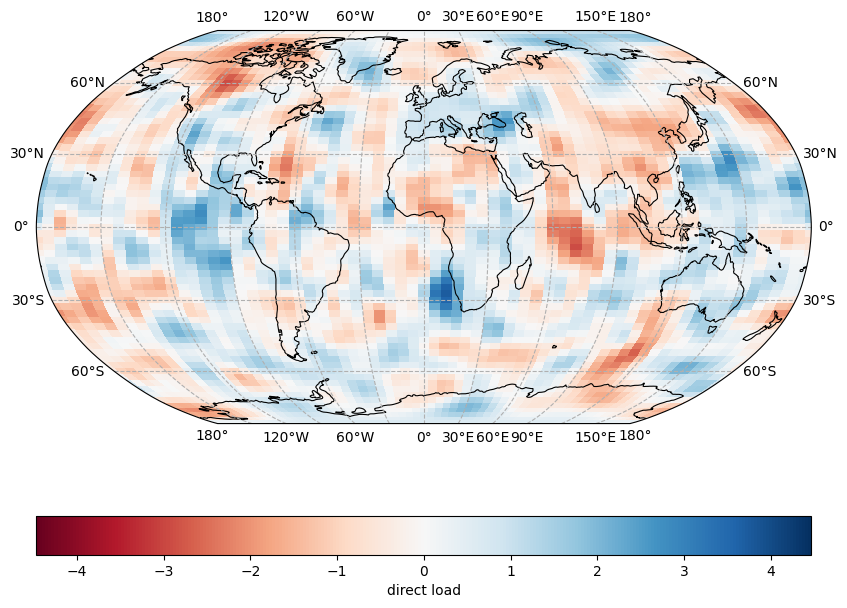

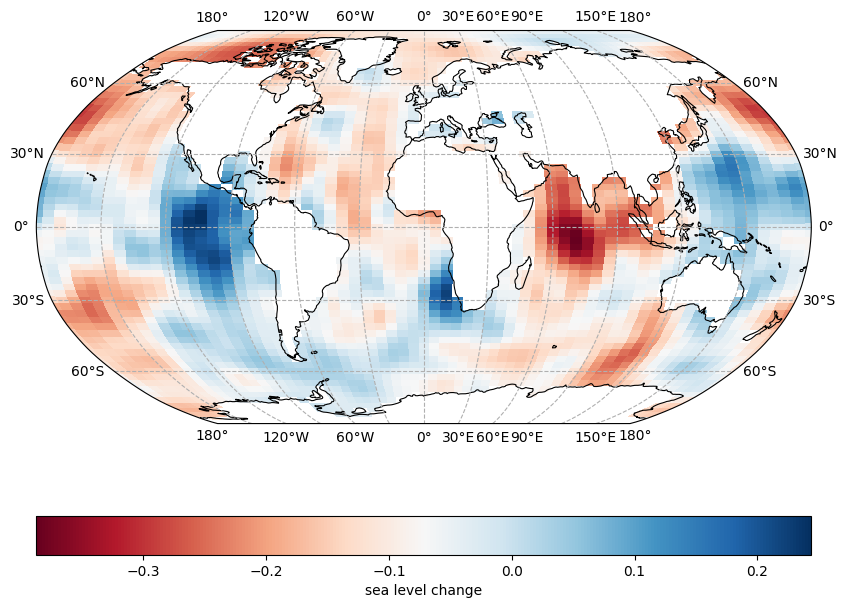

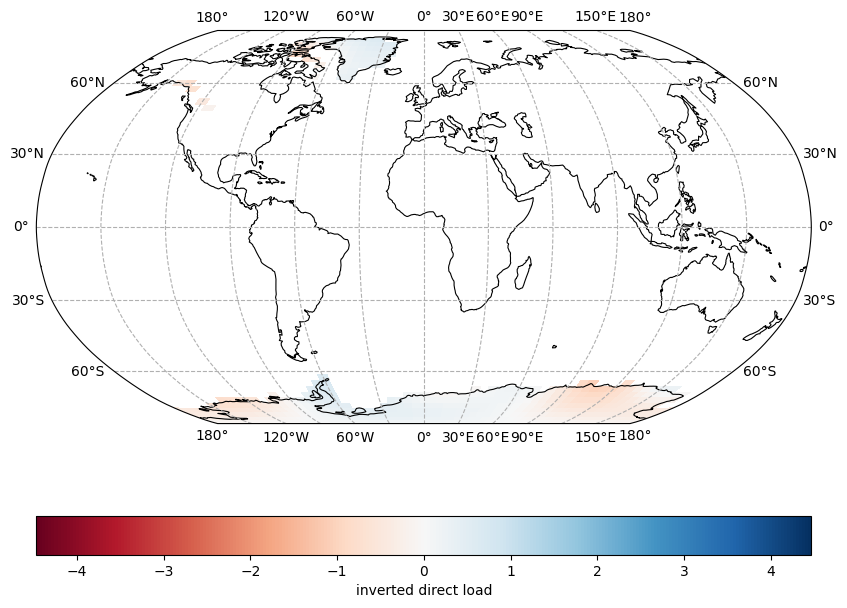

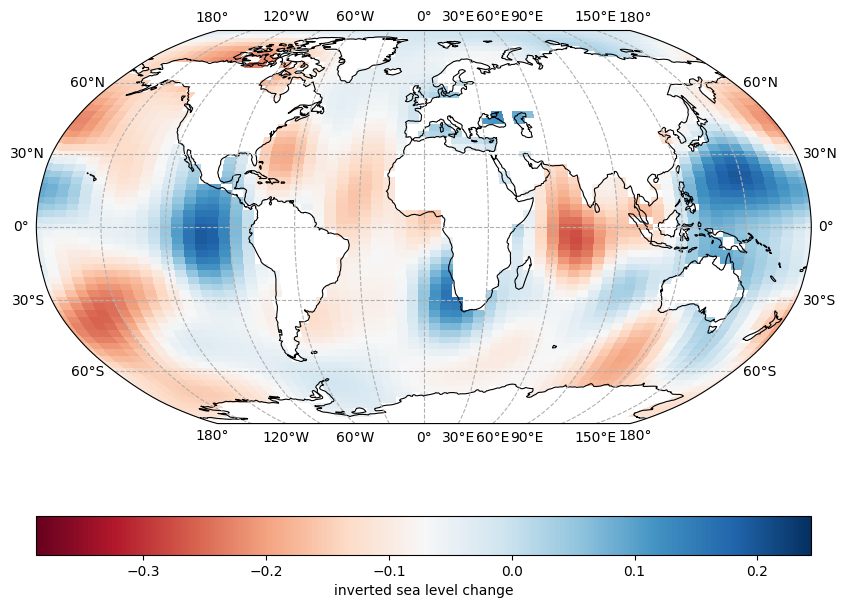

In [ ]:
# Set up the inversion
inversion = inf.LinearBayesianInversion(gfp, model_prior_measure)

# Generate synthetic data.
model, data = gfp.synthetic_model_and_data(model_prior_measure)
sea_level_change = sea_level_operator(model)[0]

# Plot the direct load input.
fig, ax, im = sl.plot(model, symmetric=True)
model_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="direct load")

# Plot the resulting sea level
fig, ax, im = sl.plot(sea_level_change * fingerprint.ocean_projection())
sea_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="sea level change")

# Invert the data.
pi = inversion.model_posterior_measure(data, inf.CGMatrixSolver())
inverted_model = pi.expectation
inverted_sea_level_change = sea_level_operator(inverted_model)[0]

# Plot the inverted direct load input.
fig, ax, im = sl.plot(inverted_model * fingerprint.ice_projection())
im.set_clim(model_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted direct load")

# Plot the resulting sea level
fig, ax, im = sl.plot(inverted_sea_level_change * fingerprint.ocean_projection())
im.set_clim(sea_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted sea level change")

print(f"global mean sea level change = {fingerprint.ocean_average(sea_level_change)}")
print(
    f"estimated global mean sea level change = {fingerprint.ocean_average(inverted_sea_level_change)}"
)
